In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from math import pi,atan,sqrt,pow



# Actividad: Histograma de Gradientes Orientados:
- Luis Dario
- Luis Felipe Flores
- Luis Alberto Fernandez
 
En esta actividad, se obtendrá el histograma de gradientes orientados de 3 clases distintas de señales de tránsito. Se comenzará importando las imágenes.


In [2]:
def getImages(imagePath):
    os.chdir(imagePath)
    imageFiles = os.listdir()
    images = [cv2.imread(image) for image in imageFiles]
    os.chdir("../")
    os.chdir("../")
    return images


In [3]:
# Extraer las imagenes del directorio
IMAGE_FOLDERS = ["señal_" + str(i) for i in range(1,4,1)]
IMAGE_PATHS = [os.path.join("Señales",folder) for folder in IMAGE_FOLDERS]
IMAGE_LIST = [getImages(path) for path in IMAGE_PATHS ]

type1 = IMAGE_LIST[0]
type2 = IMAGE_LIST[1]
type3 = IMAGE_LIST[2]



In [4]:
os.getcwd()

'c:\\Users\\luisd\\OneDrive\\Documentos\\Actividades_Goalberto\\TareaFinal'

Las imagenes se muestran a continuación:

In [5]:
OVERALL = type1+type2+type3
print(len(OVERALL))

15


In [6]:
def plotImages(dataSet,rows = 3,cols = 5):
    fig,axes = plt.subplots(rows,cols,figsize=(15,10))
    for index,axis in enumerate(axes.flat):
        img = dataSet[int(index)]
        if len(img.shape) == 2:
            axis.imshow(img, cmap='gray')
        else:
            axis.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
        

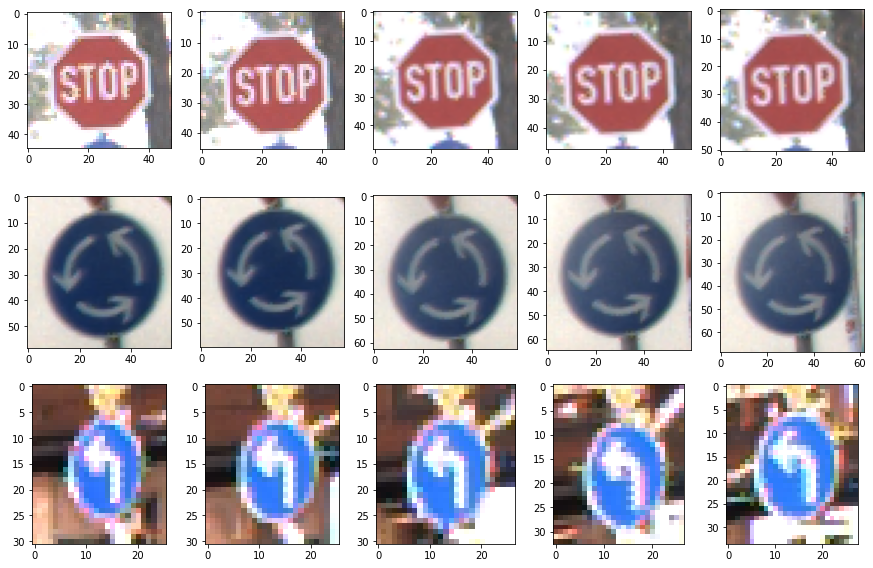

In [7]:
plotImages(OVERALL)

# Segmentación de Imágenes:
En la siguiente sección, se procede a usar la técnica de OTSU para obtener el valor ideal para segmentar la imagen.


In [8]:
# nuestra implementación manual de una función para segementar imagenes
def imageSegmentation(img):
    blur = cv2.GaussianBlur(img,(5,5),0)
    ret3,th2 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    h,w = img.shape
    umbral = int(ret3)
    for i in range(h):
        for j in range(w):
            if img[i][j] > umbral:
                img[i][j] = 255
            else:
                continue

    return img


### Proceso de Segmentación:
- Transformación en escala de grises
- Segmentación de OTSU
- Escalar a 48x48 pixeles

In [9]:
# convertir a escala de greses
PIXEL_DIM = 48
GRAYSCALE = [cv2.cvtColor(image,cv2.COLOR_BGR2GRAY) for image in OVERALL]
SEGMENTED = [imageSegmentation(gray) for gray in GRAYSCALE]
RESIZE = [cv2.resize(s,(PIXEL_DIM,PIXEL_DIM)) for s in SEGMENTED]


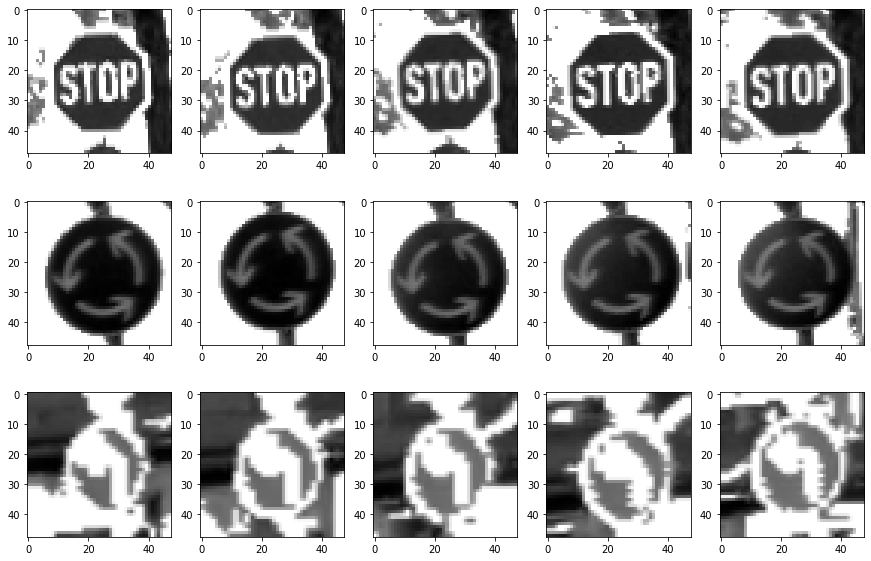

In [10]:
plotImages(RESIZE)

# Obtención del Histograma de Gradientes Orientados Normalizado:
La idea de este método es similar a la obtención de gradiente del histograma, pero con la diferencia de que ahora se obtendrá el histograma agrupado en celdas de 8x8. Para este propósito, se definieron las siguientes funciones:


Esta función recibe un segmento de la imagen de 8x8 como parámetro y regresa los vectores de gradientes correspondientes en X y Y.

In [11]:

def computeGradients(img = None):
    img = np.float32(img)
    gradientsX = list()
    gradientsY = list()
    h,w = img.shape
    for x in range(1,h-1):
        for y in range(1,w-1):
            dx = img[x+1,y]-img[x-1,y]
            dy = img[x,y+1]-img[x,y-1]
            if dx == 0:
                dx = 0.01
            if dy == 0:
                dy = 0.01
            gradientsX.append(dx)
            gradientsY.append(dy)
    return gradientsX,gradientsY


 
Esta función recibe una imagen en escala de grises como parámetro y regresa una matriz donde cada celda corresponde
a una dupla con los vectores  de gradientes X y Y de un bloque 8x8. Las coordenadas de la celda corresponden con la
posición del bloque en la imagen original.


In [12]:
def obtainGradientsMatrix(gray):
    matrix = list()
    h,w = gray.shape
    dims = 8
    for i in range(0,h-1,dims):
        row = list()
        for j in range(0,w-1,dims):
            matt = gray[i:i+dims,j:j + dims]
            gradsX, gradsY = computeGradients(matt)
            row.append((gradsX,gradsY))
        matrix.append(row)
    return np.array(matrix)

 
Estas funciones sirven para computar la magnitud y ángulo de los gradientes respectivamente. Ambas reciben una dupla de vectores de gradientes como parámetro y un vector de ángulos y magnitudes respectivamente:


In [13]:

def getMagnitude(tupp):
    magnitudes = list()
    gradientsX = tupp[0]
    gradientsY = tupp[1]
    for i in range(len(gradientsY)):
        magnitudes.append(sqrt(gradientsX[i]**2+gradientsY[i]**2))
    return magnitudes


def getAngles(tupp):
    angles = list()
    gradientsX = tupp[0]
    gradientsY = tupp[1]
    for i in range(len(gradientsY)):
        angle = atan(gradientsY[i]/gradientsX[i])
        if angle < 0:
            angle = abs(angle)
        angles.append(angle)

    angles = [angle * 180/pi for angle in angles]
    return angles


La siguiente función sirve para obtener los intervalos que se usarán para clasificar los gradientes según su ángulo, y un vector que servirá para sumar las magnitudes.


In [14]:
def getIntervals():
    interval = 180//10

    intervals = list(range(0+interval,180+interval,interval))
    plotX = list()
    for i in range(len(intervals)-1):
        plotX.append(0)
    return intervals

 
La siguiente función sirve para obtener el histograma de una celda de 8x8 dados sus magnitudes y sus ángulos.


In [15]:
def getHistogramVectors(magnitudes,angles,intervals):
    plotX = [0] * (len(intervals)-1)
    for i in range(len(magnitudes)):
        for j in range(1,len(intervals),1):
            if angles[i] > intervals[j-1] and angles[i] < intervals[j]:
                plotX[j] += magnitudes[i]
    return plotX
            

Las siguientes sirven para obtener un vector de gradientes orientados a partir de una celda de 8x8:
- Obtener los vectores de cada celda individual.
- Concatenar los vectores.
- Normalizar usando la norma L2.


In [16]:
# paso 3:
def normalize(vector,epsilon = 0.01):
    vec = np.array(vector)
    return vec/np.sqrt(np.sum(np.power(vec,2))+epsilon)

    
# pasos 1 y 2
def getConcatenatedHOG(cell):
    inter = getIntervals()
    concatenate = list()
    h,w = cell.shape[0:2]
    for i in range(h):
        for j in range(w):
            tupp = list(cell[i,j,:,:])
            magnitude = getMagnitude(tupp)
            angle = getAngles(tupp)
            vector = getHistogramVectors(magnitude,angle,inter)
            concatenate+=vector
    return normalize(concatenate)



        

# Obtención del vector característico de la imagen:
Esta función itera por la matriz de celdas de 8x8 y obtiene el histograma del vector de gradientes orientados:
- Tiene pasos de 2 celdas para poder extraer una submatriz de 2x2 celdas en cada iteración (cada celda tiene una dimensión de 8x8 pixeles).
- Para cada submatriz computa el vector normalizado de gradientes orientados asociado a cada submatriz.
- Concatena los vectores en orden y regresa el vector final.


In [17]:
def obtainHOG(img):
    
    gradientMatrix = obtainGradientsMatrix(img)
    steps = 2
    h,w = gradientMatrix.shape[0:2]
    vecChar = np.empty((1))
    for i in range(0,h,steps):
        for j in range(0,w,steps):
            subMat = gradientMatrix[i:i+steps,j:j+steps,:,:]
            vector = getConcatenatedHOG(subMat)
            vecChar = np.concatenate((vecChar,vector),axis= None)
    return vecChar
    

In [18]:
# obtener vectores normaizados para las 15 imagenes:
NORM_VECTS = [obtainHOG(img) for img in RESIZE]

In [19]:
len(NORM_VECTS)

15

In [20]:
def plotVectors(vectors,rows = 3,cols = 5):
    fig,axes = plt.subplots(rows,cols,figsize=(15,10))
    for index,axis in enumerate(axes.flat):
        vector = vectors[index]
        if index >= 0 and index < 5:
            plt.title("Imagen Tipo 1")
            axis.plot(vector,color = "b")
        elif index >= 5 and index < 10:
            plt.title("Imagen Tipo 2")
            axis.plot(vector,color = "r")
        else:
            plt.title("Imagen Tipo 3")
            axis.plot(vector,color = "g")   

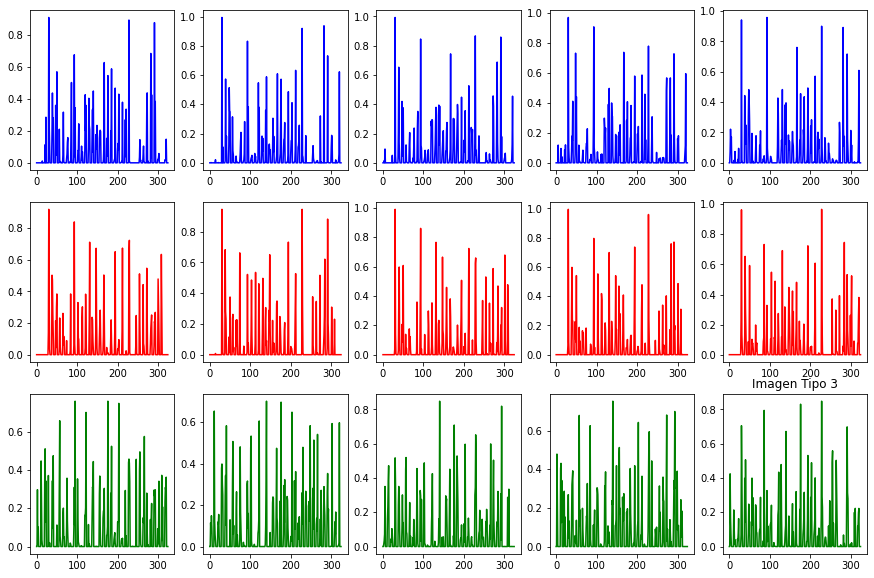

In [21]:
plotVectors(NORM_VECTS)


 
En la figura anterior se muestran los vectores de gradientes orientados para cada una de las imágenes. El color de la gráfica representa el tipo de señal de tránsito contenida en la imagen:
- Azul -> stop
- Rojo -> around
- Verde -> left
 
Nótese que todas las imágenes tienen histogramas parecidos con el resto de las imágenes de la categoría a la que pertenecen. Esto se nota mejor a continuación:


In [22]:
def overlapHistograms(vector,color):
    for hist in vector:
        plt.plot(hist,color = color)

In [23]:
STOP = NORM_VECTS[0:5]
AROUND = NORM_VECTS[5:10]
LEFT = NORM_VECTS[10:]

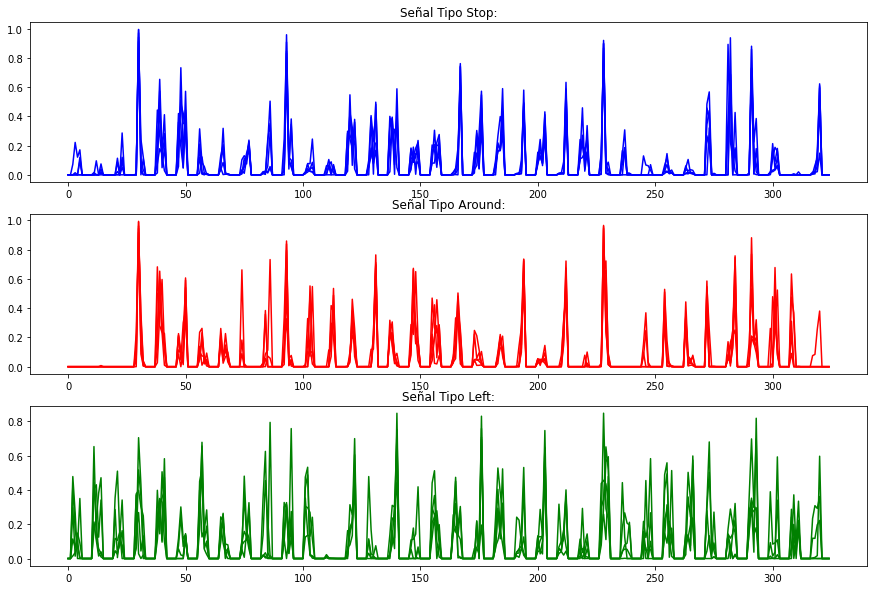

In [24]:
plt.figure(figsize=(15,10))
plt.subplot(3,1,1)
plt.title("Señal Tipo Stop:")
overlapHistograms(STOP,"b")
plt.subplot(3,1,2)
plt.title("Señal Tipo Around:")
overlapHistograms(AROUND,"r")
plt.subplot(3,1,3)
plt.title("Señal Tipo Left:")
overlapHistograms(LEFT,"g")